In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import lstm_models as models

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, CuDNNGRU, LSTM, GRU, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
import re
import zipfile

Using TensorFlow backend.


In [36]:
def read_csv(prefix=''):
    train_data = pd.read_csv('../../data/{}train_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    dev_data = pd.read_csv('../../data/{}dev_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    test_data = pd.read_csv('../../data/{}test_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    return train_data, dev_data, test_data

train_data, dev_data, test_data = read_csv('no_stemming_')

In [6]:
train_data.head(10)

,text,sentiment
0,can someone fix twitter please smell of aquati...,0
1,just walked up stopped story escalator at peac...,0
2,yes theres proof two lovebirds going to enjoy,4
3,im so sorry youtube video accidentally deleted...,0
4,want to go home now come back on thursday,0
5,mmmm shamrat arrived,4
6,going round aunites in pool x,4
7,cheers buddy will good seeing last night bit o...,4
8,sorry to hear will come kick ass in days if wa...,0
9,think time to retire saab,0


In [37]:
X_train = train_data['text'].values
X_dev = dev_data['text'].values
X_test = test_data['text'].values

print('train_data: ' + str(len(X_train)))
print('dev_data: ' + str(len(X_dev)))
print('test_data: ' + str(len(X_test)))

train_data: 1024000
dev_data: 256000
test_data: 320000


In [38]:
max_fatures = 20000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train)

In [39]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)

X_dev = tokenizer.texts_to_sequences(X_dev)
X_dev = pad_sequences(X_dev, maxlen=X_train.shape[1])

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

In [40]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_dev: {}'.format(X_dev.shape))
print('The shape of X_test: {}'.format(X_test.shape))

The shape of X_train: (1024000, 111)
The shape of X_dev: (256000, 111)
The shape of X_test: (320000, 111)


In [41]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_dev = pd.get_dummies(dev_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values

print('The shape of Y_train: {}'.format(Y_train.shape))
print('The shape of Y_dev: {}'.format(Y_dev.shape))
print('The shape of Y_test: {}'.format(Y_test.shape))

The shape of Y_train: (1024000, 2)
The shape of Y_dev: (256000, 2)
The shape of Y_test: (320000, 2)


In [42]:
np.save('../../sequence/x_train_word_20000', X_train)
np.save('../../sequence/x_dev_word_20000', X_dev)
np.save('../../sequence/x_test_word_20000', X_test)
np.save('../../sequence/y_train', Y_train)
np.save('../../sequence/y_dev', Y_dev)
np.save('../../sequence/y_test', Y_test)

In [17]:
def load_sequence(max_features):
    X_train = np.load('../../sequence/x_train_word_{}.npy'.format(max_features))
    X_dev = np.load('../../sequence/x_dev_word_{}.npy'.format(max_features))
    X_test = np.load('../../sequence/x_test_word_{}.npy'.format(max_features))
    Y_train = np.load('../../sequence/y_train.npy')
    Y_dev = np.load('../../sequence/y_dev.npy')
    Y_test = np.load('../../sequence/y_test.npy')
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [18]:
max_features = 20000
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_sequence(max_features)

We should explore LSTM, CuDNNLSTM, GRU, CuDNNGRU cells. CuDNN cells have following limitations: 1. The activation function has to be `tanh`. 2. It doesn't support recurrent dropout.

## Vanilla CuDNNLSTM with Random Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 117, 200)          0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 4,121,002
Trainable params: 4,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/2
1024000/1024000 [==============================] - 453s 443us/step - loss: 0.4270 - acc: 0.8020 - val_loss: 0.4065 - val_acc: 0.8147
Epoch 2/2
1024000/1024000 [==============================] - 45

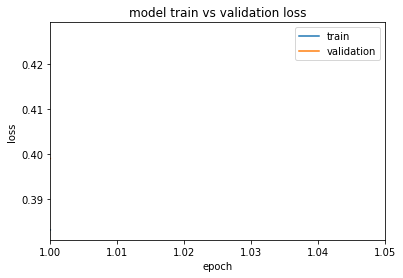

320000/320000 [==============================] - 38s 118us/step
score: 0.39681336
acc: 0.82010156


In [22]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 2,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': False,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## Deep CuDNNLSTM with Random Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 117, 200)          0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 117, 100)          120800    
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 4,201,802
Trainable params: 4,201,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/2
1024000/1024000 [==============================] - 797s 778us/st

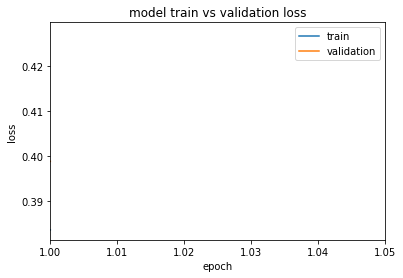

320000/320000 [==============================] - 69s 215us/step
score: 0.39721988
acc: 0.81889531


In [23]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 2,
    'rnn_dim': 100,
    'rnn_layer_num': 2,
    'input_length': X_train.shape[1],
    'input_dropout': 0,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': False,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## Bidirectional CuDNNLSTM with Random Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 117, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               241600    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 402       
Total params: 4,242,002
Trainable params: 4,242,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/2
1024000/1024000 [==============================] - 835s 815us/step - loss: 0.4278 - acc: 0.8013 - val_loss: 0.4065 - val_acc: 0.8145
Epoch 2/2
1024000/1024000 [==============================] - 82

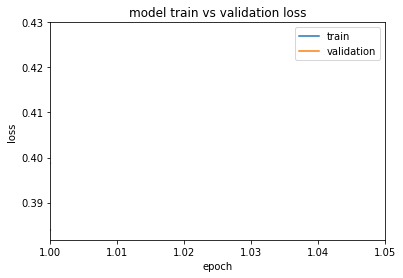

320000/320000 [==============================] - 73s 229us/step
score: 0.39787171
acc: 0.81912812


In [29]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 2,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with Dropout and Random Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 117, 200)          0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 100)               120800    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 202       
Total params: 4,121,002
Trainable params: 4,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/3
1024000/1024000 [==============================] - 473s 462us/step - loss: 0.4333 - acc: 0.7979 - val_loss: 0.4123 - val_acc: 0.8108
Epoch 2/3
1024000/1024000 [==============================] - 47

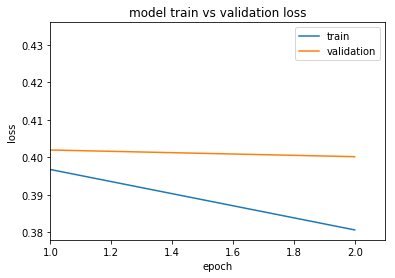

320000/320000 [==============================] - 39s 122us/step
score: 0.39847215
acc: 0.81892500


In [30]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 3,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': False,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with Dropout and Glove Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 111, 200)          74377000  
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 111, 200)          0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 100)               120800    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 74,498,002
Trainable params: 74,498,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/2
1024000/1024000 [==============================] - 1688s 2ms/step - loss: 0.4112 - acc: 0.8110 - val_loss: 0.3913 - val_acc: 0.8232
Epoch 2/2
1024000/1024000 [==============================] - 1

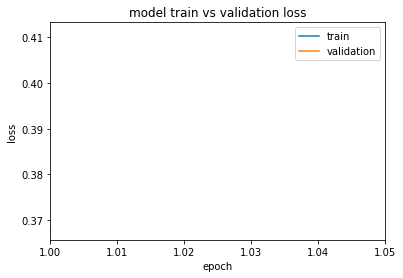

320000/320000 [==============================] - 1362s 4ms/step
score: 0.38826618
acc: 0.82500781


In [42]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'pretrained',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': tokenizer.word_index,
    'embedding_pretrained_zip_path': '../../embeddings/glove.twitter.27B.zip',
    'embedding_pretrained_name': 'glove.twitter.27B.200d.txt',
    'epoch': 2,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': False,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

To improve:
1. The model is suffering from overfitting. We should add more dropout layers and try other regularization methods.
2. Systematically search for the optimal combination of hyperparameters
3. Try pretrained embedding, bidirectional RNN, combination of word and character level embedding (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)